# Backtest of HFEA without Tax

In [ ]:
import itertools
import pandas as pd
from pathlib import Path
from itertools import combinations
from dateutil.relativedelta import relativedelta

In [ ]:
from utils.plots import draw_growth_chart
from utils.plots import draw_correlations, compare_portfolios, draw_max_portfolio_drawdowns, draw_min_portfolio_returns
from utils.math import gmean, normalize
from utils.math import normalize_df
from utils.portfolio import Portfolio

In [ ]:
# load raw and clean data
clean_data_path = Path("clean_data")
cache_path = Path("cached_data")

## Backtest with original HFEA Data

In [ ]:
# get preprocessed HFEA data and convert to have useable index
hfea_data = pd.read_excel(clean_data_path / "hfea_data.xlsx", index_col = 0)
hfea_data.index = pd.to_datetime(hfea_data.index)
hfea_data.head()

In [ ]:
p_hfea_wo_rebalancing = Portfolio(
    {
        'UPRO': 50.0,
        'TMF': 50.0,
    },
    start_value = 2000,
)

p_hfea_wo_rebalancing_result = p_hfea_wo_rebalancing.backtest(hfea_data)
p_hfea_wo_rebalancing_result.head()

In [ ]:
compare_portfolios(
    {
        'TMF/UPRO w/o rebalancing': p_hfea_wo_rebalancing_result
    },
    details=False,
)

If we compare our results to the result of an unbalanced portfolio with 50% UPRO and 50% TMF, which uses the original data, we see a good fit. The portfolio value is exactly the same, also min. and max. returns are the same. We have some differences in the CAGR calculation, but those are minor.

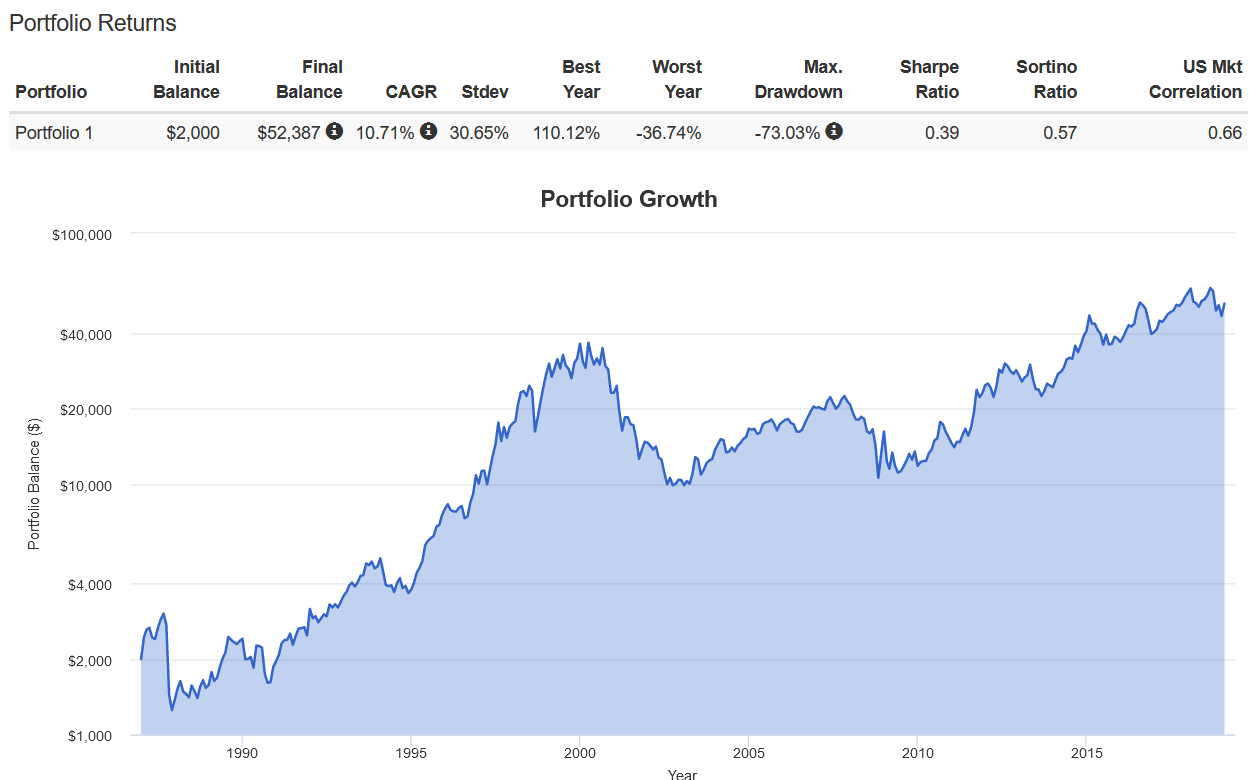

TODO: add this into the images folder

In [ ]:
p_hfea_w_rebalancing = Portfolio(
    {
        'UPRO': 40.0,
        'TMF': 60.0,
    },
    start_value = 2000,
    rebalancing = relativedelta(months=3),
    rebalancing_offset = relativedelta(days=-6),
)

p_hfea_w_rebalancing_result = p_hfea_w_rebalancing.backtest(hfea_data)
p_hfea_w_rebalancing_result.head() 

In [ ]:
compare_portfolios(
    {
        'TMF/UPRO with rebalancing': p_hfea_w_rebalancing_result
    },
    details=False,
)

And again, we have a similar performance as in the original HFEA backtest. The CAGR and min. performance is slightly different but has the same magnitude. The maximum performance is exactly the same. The differences might also come from a slighlty different timing in rebalancing. 

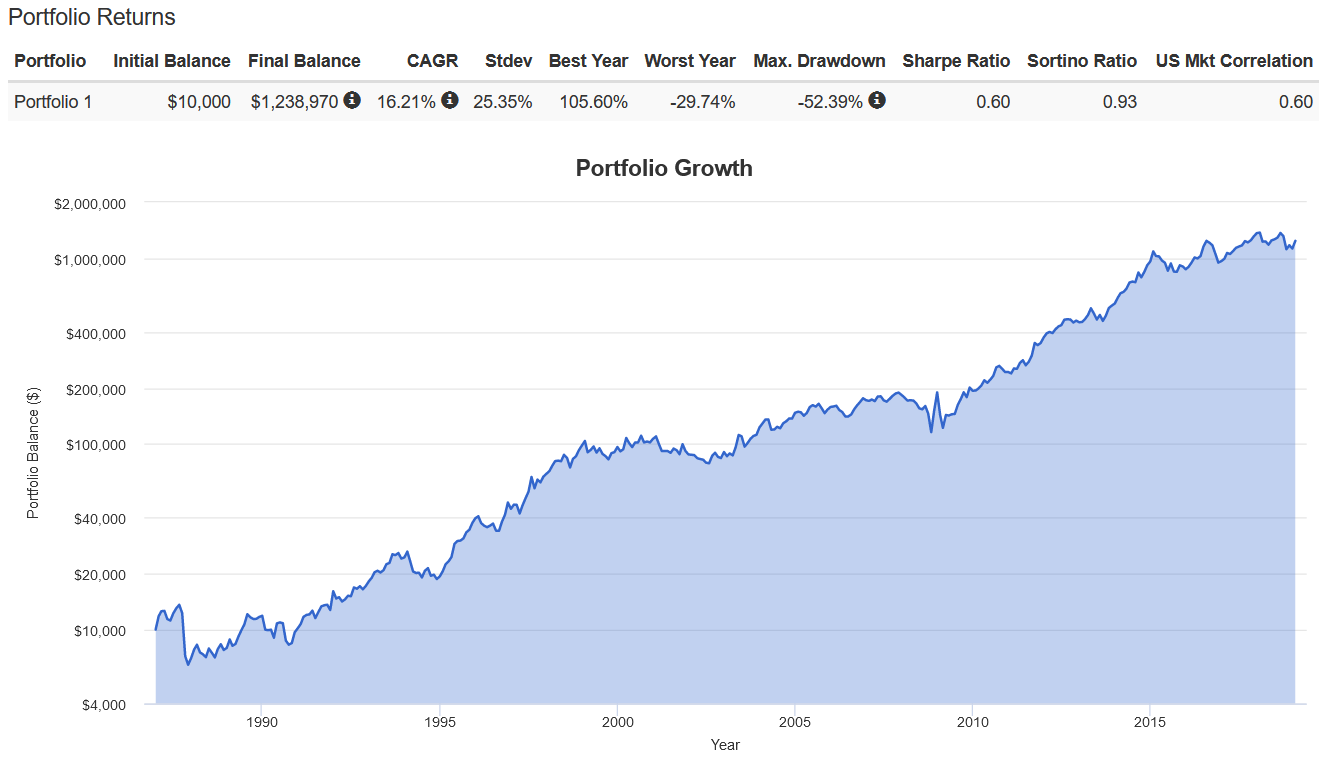

TODO: add this into the images folder

In [ ]:
draw_growth_chart(
    {
        'UPRO': normalize(hfea_data['UPRO'].loc['2007':'2014'], start_value=100000),
        'TMF': normalize(hfea_data['TMF'].loc['2007':'2014'], start_value=100000),
        'HFEA': normalize(p_hfea_w_rebalancing_result['sum'].loc['2007':'2014'], start_value=100000),
    }
)

In [ ]:
draw_growth_chart(
    {
        'UPRO': normalize(hfea_data['UPRO'], start_value=100000),
        'TMF': normalize(hfea_data['TMF'], start_value=100000),
        'HFEA': normalize(p_hfea_w_rebalancing_result['sum'], start_value=100000),
    }
)

## Backtest with our Data

In [ ]:
# get preprocessed ETF data and convert to have useable index
input_path = clean_data_path / "etfs.xlsx"
etfs = pd.read_excel(input_path, index_col=0)
etfs.index = pd.to_datetime(etfs.index)
etfs['cash'] = 100.0
etfs.head()

In [ ]:
p_hfea_old = Portfolio(
    {
        '3x_sp500_us': 40.0,
        '3x_ltt_us': 60.0,
    },
    start_value = 2000,
    rebalancing = relativedelta(months=3),
    rebalancing_offset = relativedelta(days=-6),
)

p_hfea_old_result = p_hfea_old.backtest(etfs.loc[min(hfea_data.index):max(hfea_data.index),:])

In [ ]:
compare_portfolios(
    {
        '60% TMF / 40% UPRO (Original Data)': p_hfea_w_rebalancing_result,
        '60% TMF / 40% UPRO (Our Data)': p_hfea_old_result,
    },
    details=False,
)

As we can see the growth of HFEA portfolios with our data and the simulated data from Hedgefundie is almost the same. 

In [ ]:
p_hfea_old_result = p_hfea_old.backtest(etfs)

In [ ]:
p_hfea = Portfolio(
    {
        '3x_sp500_us': 55.0,
        '3x_ltt_us': 45.0,
    },
    start_value = 2000,
    rebalancing = relativedelta(months=3),
    rebalancing_offset = relativedelta(days=-6),
)

p_hfea_result = p_hfea.backtest(etfs)

In [ ]:
p_upro_result = Portfolio({'3x_sp500_us':100}, start_value=100).backtest(etfs)

First we compare the result of the two different allocations from 1943 to 1986.

In [ ]:
compare_portfolios(
    {
        '60% TMF / 40% UPRO': normalize_df(p_hfea_old_result.loc[:'1986',:], start_value=1000),
        '45% TMF / 55% UPRO': normalize_df(p_hfea_result.loc[:'1986',:], start_value=1000),
        'UPRO': normalize_df(p_upro_result.loc[:'1986',:], start_value=1000),        
    },
    ['60%', '45%', 'UPRO'],
    details=True,
)

Second we compare the result of the two different allocations 1986 to today.

In [ ]:
compare_portfolios(
    {
        '60% TMF / 40% UPRO': normalize_df(p_hfea_old_result.loc['1986':,:], start_value=1000),
        '45% TMF / 55% UPRO': normalize_df(p_hfea_result.loc['1986':,:], start_value=1000),
        'UPRO': normalize_df(p_upro_result.loc['1986':,:], start_value=1000),
    },
    ['60%', '45%', 'UPRO'],
    details=True,
)

Last we can compare the result of the two different allocations in the full period from 1943 to today.

In [ ]:
compare_portfolios(
    {
        '60% TMF / 40% UPRO': p_hfea_old_result,
        '45% TMF / 55% UPRO': p_hfea_result,
        'UPRO': p_upro_result,        
    },
    ['60%', '45%', 'UPRO'],
    details=True,
)

## Different Leverage Levels of HFEA

In [ ]:
# Define S&P 500 and HFEA as baseline
p_sp500 = Portfolio(
    {
        '1x_sp500_eu': 100.0,
    },
    start_value = 1000,
).backtest(etfs)

p_hfea = Portfolio(
    {
        '3x_sp500_us': 55.0,
        '3x_ltt_us': 45.0,
    },
    start_value = 1000,
    rebalancing = relativedelta(months=3),
    rebalancing_offset = relativedelta(days=-6),
).backtest(etfs)

In [ ]:
# define several possible combinations of leverages and hedges
allocations = [55]  # Share allocation
leverages = [
    ('1x_sp500_us', '1x_ltt_us'),
    ('1x_sp500_us', '2x_ltt_us'),
    ('1x_sp500_us', '3x_ltt_us'),
    ('2x_sp500_us', '1x_ltt_us'),
    ('2x_sp500_us', '2x_ltt_us'),
    ('2x_sp500_us', '3x_ltt_us'),
    ('3x_sp500_us', '1x_ltt_us'), 
    ('3x_sp500_us', '2x_ltt_us'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)  

In [ ]:
# define several possible combinations of leverages and hedges until 1986
allocations = [55]  # Share allocation
leverages = [
    ('1x_sp500_us', '1x_ltt_us'),
    ('1x_sp500_us', '2x_ltt_us'),
    ('1x_sp500_us', '3x_ltt_us'),
    ('2x_sp500_us', '1x_ltt_us'),
    ('2x_sp500_us', '2x_ltt_us'),
    ('2x_sp500_us', '3x_ltt_us'),
    ('3x_sp500_us', '1x_ltt_us'),
    ('3x_sp500_us', '2x_ltt_us'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs.loc[:'1986', :])
    
portfolios['HFEA'] = p_hfea.loc[:'1986', :]
short_names.append("HFEA")
portfolios['S&P500'] = p_sp500.loc[:'1986', :]
short_names.append('S&P500')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)  

In [ ]:
# define several possible combinations of leverages and hedges from 1986 onwards (NOTE: HFEA- performs far worse from 1986-today!)
allocations = [55]  # Share allocation
leverages = [
    ('1x_sp500_us', '1x_ltt_us'),
    ('1x_sp500_us', '2x_ltt_us'),
    ('1x_sp500_us', '3x_ltt_us'),
    ('2x_sp500_us', '1x_ltt_us'),
    ('2x_sp500_us', '2x_ltt_us'),
    ('2x_sp500_us', '3x_ltt_us'),
    ('3x_sp500_us', '1x_ltt_us'), 
    ('3x_sp500_us', '2x_ltt_us'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs.loc['1986':, :])
    
portfolios['HFEA'] = p_hfea.loc['1986':, :]
short_names.append("HFEA")
portfolios['S&P500'] = p_sp500.loc['1986':, :]
short_names.append('S&P500')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)  

So, we decide to introduce a new allocation with the name `HFEA-`, which has 55% 3x S&P 500 and 45% 1x LTT.

## Different S&P 500 and LTT Allocations

In [ ]:
# create two new baselines: HFEA- and HFEA 50/50
p_hfea_m = Portfolio(
    {
        '3x_sp500_us': 55.0,
        '1x_ltt_us': 45.0,
    },
    start_value = 1000,
    rebalancing = relativedelta(months=3),
    rebalancing_offset = relativedelta(days=-6),
).backtest(etfs)

p_pari = Portfolio(
    {
        '1x_sp500_eu': 60.0,
        '1x_ltt_eu': 40.0,
    },
    start_value = 1000,
    rebalancing = relativedelta(months=3),
    rebalancing_offset = relativedelta(days=-6),
).backtest(etfs)

In [ ]:
# unleveraged portfolios, but with different proportions
portfolios = {}
short_names = []
for p in range(0,100,5):
    if p == 60:
        continue
    name = f"{p}%/{100-p}%"
    short_names.append(f"{p}%")
    portfolios[name] = Portfolio(
        {
            '1x_sp500_eu': p,
            '1x_ltt_eu': 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['HFEA-'] = p_hfea_m
short_names.append("HFEA-")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)    

We now chose 80%, 65%, 50% as References and calculate them with 1x/1x, 1x/3x, 2x/1x, 2x/3x, 3x/1x, 3x/3x leverage between S&P 500 and LTT/ITT. 

In [ ]:
allocations = [55]
leverages = [
    ('1x_sp500_eu', '1x_ltt_eu'),
    ('1x_sp500_eu', '3x_itt_eu'),
    ('2x_sp500_eu', '1x_ltt_eu'),
    ('2x_sp500_eu', '3x_itt_eu'),
    ('3x_sp500_eu', '1x_ltt_eu'),
    ('3x_sp500_eu', '3x_itt_eu'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{p}%;{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['HFEA-'] = p_hfea_m
short_names.append("HFEA-")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)    

As we can see, on 50% allocation for S&P 500, the 3x ITT portfolios perform worse then the 1x ITT Portfolios and even have higher risk. On the other side, as expected the 2x S&P 500 portfolios perform better then 1x S&P 500 and eben better perform the 3x S&P 500 portfolios. 

In [ ]:
allocations = [65]
leverages = [
    ('1x_sp500_eu', '1x_ltt_eu'),
    ('1x_sp500_eu', '3x_itt_eu'),
    ('2x_sp500_eu', '1x_ltt_eu'),
    ('2x_sp500_eu', '3x_itt_eu'),
    ('3x_sp500_eu', '1x_ltt_eu'),
    ('3x_sp500_eu', '3x_itt_eu'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{p}%;{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['HFEA-'] = p_hfea_m
short_names.append("HFEA-")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)    

In [ ]:
allocations = [80]
leverages = [
    ('1x_sp500_eu', '1x_ltt_eu'),
    ('1x_sp500_eu', '3x_itt_eu'),
    ('2x_sp500_eu', '1x_ltt_eu'),
    ('2x_sp500_eu', '3x_itt_eu'),
    ('3x_sp500_eu', '1x_ltt_eu'),
    ('3x_sp500_eu', '3x_itt_eu'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{p}%;{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['HFEA-'] = p_hfea_m
short_names.append("HFEA-")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
)  

If the S&P 500 allocation is at 80%, the 3x ITT portfolios have always a slightly lower risk over the 1x LTT portfolios. With 80% 3x S&P 500, we almost reach the same performance as HFEA, but with more than 15% higher drawdown risk. 

In [ ]:
allocations = [50, 65, 80]
leverages = [
    ('2x_sp500_eu', '1x_ltt_eu'),
    ('3x_sp500_eu', '3x_itt_eu'),
]
portfolios = {}
short_names = []

def get_lev(string):
    return string[:2]

for p, a in itertools.product(allocations, leverages):
    name = f"{p}%;{get_lev(a[0])};{get_lev(a[1])}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['HFEA-'] = p_hfea_m
short_names.append("HFEA-")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
) 

So we have 3 candidates with a different risk/reward profile:

* Low Risk: 50% 2x S&P 500 + 60% LTT
* Mid Risk: 65% 2x S&P 500 + 40% LTT
* High Risk: 65% 3x S&P 500 + 40% 3x ITT
  * here an alternative without emittent risk would be 80% 2x S&P 500 + 20% LTT

In a next step, we check what happens if the portfolios, use ITT instead of LTT.

In [ ]:
allocations = [
    (50, ("2x_sp500_eu", "1x_ltt_eu")),
    (50, ("2x_sp500_eu", "1x_itt_eu")),
    (65, ("2x_sp500_eu", "1x_ltt_eu")),
    (65, ("2x_sp500_eu", "1x_itt_eu")),
    (80, ("2x_sp500_eu", "1x_ltt_eu")),
    (80, ("2x_sp500_eu", "1x_itt_eu")),
]

def get_lev(string):
    return string[:2]

short_names = []
portfolios = {}
for p, a in allocations:
    name = f"{p}%;{get_lev(a[0])};{a[1][:6]}"
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[0]: p,
            a[1]: 100-p,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    

portfolios['HFEA'] = p_hfea
short_names.append("HFEA")
portfolios['HFEA-'] = p_hfea_m
short_names.append("HFEA-")
portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
) 

As we can see, LTTs lead always to higher performance. Except of 40% S&P 500 allocation, it also lead to less risk. 

Let's verify this, buy fading between 1x LTT and 3x ITT for 50%, 65% and 80% portfolios.

In [ ]:
share_allocation = 50
portfolios = {}
short_names = []
for p in range(0,101,5):
    name = f"{p}%/{100-p}%"
    short_names.append(f"{p}%")
    portfolios[name] = Portfolio(
        {
            '2x_sp500_eu': share_allocation,
            '1x_ltt_eu': ((100-share_allocation)*(p))/100,
            '3x_itt_eu': ((100-share_allocation)*(100-p))/100,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
) 

In [ ]:
share_allocation = 65
portfolios = {}
short_names = []
for p in range(0,101,5):
    name = f"{p}%/{100-p}%"
    short_names.append(f"{p}%")
    portfolios[name] = Portfolio(
        {
            '2x_sp500_eu': share_allocation,
            '1x_ltt_eu': ((100-share_allocation)*(p))/100,
            '3x_itt_eu': ((100-share_allocation)*(100-p))/100,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
) 

In [ ]:
share_allocation = 80
portfolios = {}
short_names = []
for p in range(0,101,5):
    name = f"{p}%/{100-p}%"
    short_names.append(f"{p}%")
    portfolios[name] = Portfolio(
        {
            '3x_sp500_eu': share_allocation,
            '1x_ltt_eu': ((100-share_allocation)*(p))/100,
            '3x_itt_eu': ((100-share_allocation)*(100-p))/100,
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    
compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
) 

## Summary

In [ ]:
allocations = [
    ("2x S&P 500",  ('2x_sp500_eu', 100), ('1x_ltt_eu', 0), ('1x_gold_eu', 0)),
    ("50%",         ('2x_sp500_eu', 50), ('1x_ltt_eu', 50), ('1x_gold_eu', 0)),
    ("65%",         ('2x_sp500_eu', 65), ('1x_ltt_eu', 35), ('1x_gold_eu', 0)),
    ("80%",         ('2x_sp500_eu', 80), ('1x_ltt_eu', 20), ('1x_gold_eu', 0)),
    ("65% (3x)",    ('3x_sp500_eu', 65), ('3x_itt_eu', 35), ('1x_gold_eu', 0)),
    ("HFEA",        ('3x_sp500_us', 55), ('3x_ltt_us', 45), ('1x_gold_us', 0)),
    ("HFEA-",       ('3x_sp500_us', 55), ('1x_ltt_us', 45), ('1x_gold_us', 0)),
]


short_names = []
portfolios = {}
for a in allocations:
    name = a[0]
    print(f"Calculate: {name}")
    short_names.append(name)
    portfolios[name] = Portfolio(
        {
            a[1][0]: a[1][1],
            a[2][0]: a[2][1],
            a[3][0]: a[3][1],
        },
        start_value = 1000,
        rebalancing = relativedelta(months=3),
        rebalancing_offset = relativedelta(days=-6),
    ).backtest(etfs)
    

portfolios['S&P500'] = p_sp500
short_names.append('S&P500')
portfolios['P'] = p_pari
short_names.append('P')

compare_portfolios(
    portfolios,
    short_names = short_names,
    details=True,
) 

In [ ]:
draw_max_portfolio_drawdowns(portfolios)

In [ ]:
draw_min_portfolio_returns(portfolios)

## Additional Calculations

We calculate the correlation between S&P 500 and LTT in a sliding window of 5 years and then we calculate the CAGR of S&P 500 in the same window. Both values can be visualed in a Scatterplot to check, if correlation is only in those periods positive where S&P 500 makes huge gains.

In [ ]:
def calc_correlations_and_cagr_over_time(
        daily_returns,
        yearly_returns,
        correlation_size,
        step_size,
        assets,
    ):
    correlations_over_time = pd.DataFrame()
    cagr_over_time = pd.DataFrame()
    i = min(daily_returns.index)

    counter = 0
    while True:
        counter += 1
        start_index = i
        end_index = start_index + correlation_size
        i = i + step_size
        if i + correlation_size > max(daily_returns.index):
            return correlations_over_time, cagr_over_time

        if counter >= 12:
            # remove some of the printing output, only print yearly
            counter = 0
            print(start_index)
        correlation_window = daily_returns.loc[start_index:end_index, :][assets]
        correlation_window = correlation_window.corr()

        for c in combinations(assets, 2):
            correlations_over_time.loc[end_index, f'{c[0]} vs. {c[1]}'] = correlation_window.loc[c[0], c[1]]
            
        for a in assets:
            cagr_over_time.loc[end_index, a] = gmean(yearly_returns.loc[f"{start_index.year}":f"{end_index.year}", a])        

In [ ]:
yearly_returns = etfs.pct_change(1, freq="Y")
yearly_returns = yearly_returns.dropna()
yearly_returns.head()

In [ ]:
daily_returns = etfs.pct_change(1, freq="D")
daily_returns = daily_returns.dropna()
daily_returns.head()

In [ ]:
corr, cagr = calc_correlations_and_cagr_over_time(
    daily_returns,
    yearly_returns,
    correlation_size = relativedelta(years=5),
    step_size = relativedelta(months=1),
    assets=['1x_sp500_us', '1x_ltt_us'],
)

In [ ]:
corr.head()

In [ ]:
cagr.head()

In [ ]:
combined = pd.DataFrame()
combined['1x_sp500_us vs. 1x_ltt_us'] = corr['1x_sp500_us vs. 1x_ltt_us']
combined['cagr_1x_sp500_us'] = cagr['1x_sp500_us']
combined.head()

In [ ]:
draw_growth_chart(
    {
        'ltt vs. sp500': combined['1x_sp500_us vs. 1x_ltt_us'] * 100,
        'CAGR S&P 500': combined['cagr_1x_sp500_us'] * 100,        
    },
    "Correlation over Years (5 Years Correlation) and CAGR",
    y_log=False,
    y_title="correlation/CAGR in %"
)
draw_correlations(
    combined.corr(),
    combined,
    "correlation or",
    selection=['1x_sp500_us vs. 1x_ltt_us', 'cagr_1x_sp500_us'],
    rows=1,
)